In [1]:
from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.parsers.converters.spectralis import load_spectralis_rescoring
from denovo_utils.io.read import load_psmlist

from psm_utils import PSMList
from tqdm import tqdm
from glob import glob
from itertools import chain

import pandas as pd
import os

from denovo_utils.data.run import read_runs

2025-04-18 12:59:57.068128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 12:59:57.088982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 12:59:57.095260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


In [2]:
filenames = ['LFQ_Orbitrap_DDA_QC_01']

root_mgf = f'/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_psmlist = f'/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams'
root_postprocessing = f'/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams'

format_ground_truth = 'parquet'

rescored_db = True
rescored_denovo = True
rescored_refinement = False

In [3]:
runs = read_runs(
    root_denovo_output=root_psmlist,
    root_ground_truth=root_psmlist,
    root_refinement=root_postprocessing,
    root_mgf=root_mgf,
    filenames=filenames,
    engine_names=[
        'casanovo'
    ],
    refinement_names=[
        'spectralis',
        'instanovoplus'
    ],
    format_ground_truth=format_ground_truth,
    rescored_db=rescored_db,
    rescored_denovo=rescored_denovo,
    rescored_refinement=rescored_refinement
)

Loading results from ground_truth.parquet: 100%|██████████| 83941/83941 [00:12<00:00, 6508.31it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 83941/83941 [00:05<00:00, 16035.83it/s]
Loading results from casanovo.parquet: 100%|██████████| 352220/352220 [01:05<00:00, 5413.35it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 352220/352220 [00:28<00:00, 12201.89it/s]
Parsing Instanovo+ results to PSMList: 100%|██████████| 352183/352183 [00:14<00:00, 23829.13it/s]


Ranking candidates is done by a single score. These scores can be defined in multiple ways.

Inside de novo search engines, this is the search engine score. In database search engines, this is done first by the hyperscore as a pre-filtering step.

In this notebook, we will generate multiple scoring schemes and evaluate which is best in correctly ranking the 'correct' identification the highest.

The scores under evaluation here are the following:
- Casanovo score
- MS2Rescore: Can be calculated using differing feature sets
    - Base MS2Rescore
    - MS2Rescore + Casanovo score
    - MS2Rescore + Spectralis score
    - MS2Rescore + Spectralis score + Casanovo score
- Spectralis score
- InstaNovo+ score

First, we need to fit the mokapot models using the defined feature sets. As a check, I will draw an upsetplot how this effects the database search results. Ideally, these would not change.

Importantly, if database search results change, this is not due to the same process as will be investigated here, namely, reranking PSMs on Run level. Indeed, only one candidate was provided here for each spectrum.

# Infer new PSM-scores using mokapot

To infer new PSM-scores, I will use the MS2Rescore pipeline. First, the casanovo and spectralis scores need to be appended to the feature lists.

### 1. Load features and append the casanovo and spectralis scores

In [2]:
from denovo_utils.io.read import load_features, load_psmlist
from denovo_utils.parsers.converters.spectralis import load_spectralis_rescoring

Load the features

In [25]:
root_features = '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features'
casanovo_features = pd.read_parquet(os.path.join(root_features, 'casanovo.parquet'))
gt_features = pd.read_parquet(os.path.join(root_features, 'ground_truth.parquet'))

Features are in the following dictionary format:

- key: spectrum_id
    - value: dict
        - key: rank
        - value: dict
            - key: feature_name
            - value: feature value

Add casanovo scores

In [30]:
def add_score_to_rescoring_features(rescoring_dict, score, score_name):
    rescoring_dict[score_name] = score

In [ ]:
# Load the data where the scores are stored.

# The casanovo scores for the casanovo candidates are stored in their PSMList
casanovo_psmlist = load_psmlist(
    psm_path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/psmlist/casanovo.parquet'
)

# The casanovo scores for the Ground truth are stored in a separate result file bcz seperate casanovo inference was necessary
gt_psmlist = load_psmlist(
    psm_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing/casanovo/casanovo/LFQ_Orbitrap_DDA_QC_01_casanovo.parquet'
)

Loading results from casanovo.parquet: 100%|██████████| 352220/352220 [00:56<00:00, 6224.05it/s]
Loading results from LFQ_Orbitrap_DDA_QC_01_casanovo.parquet: 100%|██████████| 83941/83941 [00:38<00:00, 2203.56it/s]


In [ ]:
# Extract the scores
score_df_casanovo_candidates = pd.DataFrame({
    'Casanovo_score': casanovo_psmlist['score'], 
    'spectrum_id': casanovo_psmlist['spectrum_id'],
    'rank': casanovo_psmlist['rank']
})

score_df_casanovo_gt = pd.DataFrame({
    'Casanovo_score': [rescoring_features['Casanovo_score'] for rescoring_features in gt_psmlist['rescoring_features']],
    'spectrum_id': gt_psmlist['spectrum_id'],
    'rank': gt_psmlist['rank']
})

In [ ]:
# Add the scores to the feature_dict

casanovo_features_merged = casanovo_features.merge(score_df_casanovo_candidates)
_ = casanovo_features_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Casanovo_score'],
        score_name='Casanovo_score'
    ),
axis=1)

,spectrum_id,rank,run,source,rescoring_features,Casanovo_score
0,controllerType=0 controllerNumber=1 scan=60355,1,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.00012205832172185183, 'abs_d...",0.946581
1,controllerType=0 controllerNumber=1 scan=60355,2,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.00014677498256787658, 'abs_d...",0.931852
2,controllerType=0 controllerNumber=1 scan=60355,3,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.00010206006118096411, 'abs_d...",0.910791
3,controllerType=0 controllerNumber=1 scan=60355,4,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.00010005271178670228, 'abs_d...",0.894044
4,controllerType=0 controllerNumber=1 scan=60355,5,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 9.21785831451416e-05, 'abs_dif...",0.891319
...,...,...,...,...,...,...
352215,controllerType=0 controllerNumber=1 scan=69011,6,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.00018163214554078877, 'abs_d...",0.874042
352216,controllerType=0 controllerNumber=1 scan=69011,7,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 6.678988575004041e-05, 'abs_di...",0.854001
352217,controllerType=0 controllerNumber=1 scan=69011,8,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 6.678988575004041e-05, 'abs_di...",0.853452
352218,controllerType=0 controllerNumber=1 scan=69011,9,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 6.678988575004041e-05, 'abs_di...",0.847426


In [27]:
score_df_casanovo_candidates.head()

,Casanovo_score,spectrum_id,rank
0,0.946581,controllerType=0 controllerNumber=1 scan=60355,1
1,0.931852,controllerType=0 controllerNumber=1 scan=60355,2
2,0.910791,controllerType=0 controllerNumber=1 scan=60355,3
3,0.894044,controllerType=0 controllerNumber=1 scan=60355,4
4,0.891319,controllerType=0 controllerNumber=1 scan=60355,5


Add Spectralis scores

In [35]:
spectralis_scores_candidates = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/spectralis/casanovo',
    filename='LFQ_Orbitrap_DDA_QC_01'
)

spectralis_scores_gt = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/spectralis/parquet',
    filename='LFQ_Orbitrap_DDA_QC_01'
)

spectralis_scores_candidates = spectralis_scores_candidates.rename(columns={'title': 'spectrum_id'})[['Spectralis_score', 'spectrum_id', 'rank']]
spectralis_scores_gt = spectralis_scores_gt.rename(columns={'title': 'spectrum_id'})[['Spectralis_score', 'spectrum_id', 'rank']]

Loading Spectralis results: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


In [39]:
casanovo_merged = casanovo_features.merge(score_df_casanovo_candidates).merge(spectralis_scores_candidates)
gt_merged = gt_features.merge(score_df_casanovo_gt).merge(spectralis_scores_gt)

In [41]:
# Add to the casanovo psmlist features
### Add Casanovo score
_ = casanovo_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Casanovo_score'],
        score_name='Casanovo_score'
    ),
    axis=1
)
### Add Spectralis score
_ = casanovo_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Spectralis_score'],
        score_name='Spectralis_score'
    ),
    axis=1
)

# Add to the ground-truth psmlist features
### Add Casanovo score
_ = gt_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Casanovo_score'],
        score_name='Casanovo_score'
    ),
    axis=1
)
### Add Spectralis score
_ = gt_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Spectralis_score'],
        score_name='Spectralis_score'
    ),
    axis=1
)

### Store the new feature sets

Due to Python's variable reference system, the dictionary in the original dataframes now already hold the scores

In [51]:
gt_features.to_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/ground_truth.parquet')
casanovo_features.to_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/casanovo.parquet')

## 2. Fit the mokapot models on the ground-truth using different feature sets

In [3]:
from denovo_utils.io.read import load_psmlist_and_features
from denovo_utils.rescoring import DeNovoRescorer

In [4]:
root_psmlist = '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/psmlist'
root_features = '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features'

# gt_psmlist = load_psmlist_and_features(
#     psm_path=os.path.join(root_psmlist, 'ground_truth.parquet'),
#     feature_path=os.path.join(root_features, 'ground_truth.parquet')
# )

casanovo_candidates_psmlist = load_psmlist_and_features(
    psm_path=os.path.join(root_psmlist, 'casanovo.parquet'),
    feature_path=os.path.join(root_features, 'casanovo.parquet')
)

Loading results from casanovo.parquet: 100%|██████████| 603540/603540 [01:34<00:00, 6384.28it/s]


In [5]:
from ms2rescore.feature_generators import MS2PIPFeatureGenerator, DeepLCFeatureGenerator

basic_features = ['charge_n', 'abs_ms1_error_ppm', 'hyperscore', 'missing_frag_count', 'missing_frag_pct']
ms2pip_features = MS2PIPFeatureGenerator(processes=1).feature_names
deeplc_features = DeepLCFeatureGenerator().feature_names
casanovo_feature = ['Casanovo_score']
spectralis_feature = ['Spectralis_score']

feature_names = {
    'Basic': basic_features,
    'MS2PIP': ms2pip_features,
    'DeepLC': deeplc_features,
    'Casanovo': casanovo_feature,
    'Spectralis': spectralis_feature
}

In [6]:
# Create feature configurations
import json
from itertools import chain
import copy
with open('/home/sam/Work_directory/DeNovo_Benchmark/configs/ms2rescore/config_default.json', 'r') as f:
    config = json.load(f)

config_1 = copy.deepcopy(config) # MS2Rescore base
config_1['ms2rescore']['rescoring_features'] = feature_names['Basic'] + feature_names['MS2PIP'] + feature_names['DeepLC']

config_2 = copy.deepcopy(config) # MS2Rescore + Casanovo score
config_2['ms2rescore']['rescoring_features'] = feature_names['Basic'] + feature_names['MS2PIP'] + feature_names['DeepLC'] + feature_names['Casanovo']

config_3 = copy.deepcopy(config) # MS2Rescore + Spectralis score
config_3['ms2rescore']['rescoring_features'] = feature_names['Basic'] + feature_names['MS2PIP'] + feature_names['DeepLC'] + feature_names['Spectralis']

config_4 = copy.deepcopy(config) # MS2Rescore + Casanovo score + Spectralis score
config_4['ms2rescore']['rescoring_features'] = feature_names['Basic'] + feature_names['MS2PIP'] + feature_names['DeepLC'] + feature_names['Casanovo'] + feature_names['Spectralis']


In [7]:
drs_1 = DeNovoRescorer(
    configuration=config_1
)

drs_2 = DeNovoRescorer(
    configuration=config_2
)

drs_3 = DeNovoRescorer(
    configuration=config_3
)

drs_4 = DeNovoRescorer(
    configuration=config_4
)

In [ ]:
# Uncomment for training new mokapot models
# drs_1.train_mokapot_models(
#     psm_list=gt_psmlist,
#     save_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_1'
# )
# drs_2.train_mokapot_models(
#     psm_list=gt_psmlist,
#     save_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_2'
# )
# drs_3.train_mokapot_models(
#     psm_list=gt_psmlist,
#     save_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_3'
# )
# drs_4.train_mokapot_models(
#     psm_list=gt_psmlist,
#     save_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_4'
# )

In [8]:
drs_1.load(
    calibration_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    mokapot_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_1'
)
drs_2.load(
    calibration_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    mokapot_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_2'
)
drs_3.load(
    calibration_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    mokapot_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_3'
)
drs_4.load(
    calibration_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    mokapot_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_4'
)

## 3. Infer new PSM-scores

### 1. Default MS2Rescore

GT

In [ ]:
drs_1.rescore(
    psm_list=gt_psmlist,
    denovo=False
)
gt_scores = {
    'spectrum_id': gt_psmlist['spectrum_id'],
    'score_default_ms2rescore': gt_psmlist['score'],
    'qvalue_default_ms2rescore': gt_psmlist['qvalue'],
}

DN

In [11]:
drs_1.rescore(
    psm_list=casanovo_candidates_psmlist,
    denovo=True
)
casanovo_candidate_scores = {
    'spectrum_id': casanovo_candidates_psmlist['spectrum_id'],
    'rank': casanovo_candidates_psmlist['rank'],
    'score_default_ms2rescore': [psm['score_ms2rescore'] for psm in casanovo_candidates_psmlist['provenance_data']]
}

### 2. Default MS2Rescore + casanovo

In [ ]:
drs_2.rescore(
    psm_list=gt_psmlist,
    denovo=False
)
gt_scores['score_ms2rescore_casanovo'] = gt_psmlist['score']
gt_scores['qvalue_ms2rescore_casanovo'] = gt_psmlist['qvalue']

In [12]:
drs_2.rescore(
    psm_list=casanovo_candidates_psmlist,
    denovo=True
)
casanovo_candidate_scores['score_ms2rescore_casanovo'] = [psm['score_ms2rescore'] for psm in casanovo_candidates_psmlist['provenance_data']]

### 3. Default MS2Rescore + spectralis

In [ ]:
drs_3.rescore(
    psm_list=gt_psmlist,
    denovo=False
)
gt_scores['score_ms2rescore_spectralis'] = gt_psmlist['score']
gt_scores['qvalue_ms2rescore_spectralis'] = gt_psmlist['qvalue']

In [13]:
drs_3.rescore(
    psm_list=casanovo_candidates_psmlist,
    denovo=True
)
casanovo_candidate_scores['score_ms2rescore_spectralis'] = [psm['score_ms2rescore'] for psm in casanovo_candidates_psmlist['provenance_data']]

### 4. Default MS2Rescore + casanovo + spectralis

In [ ]:
drs_4.rescore(
    psm_list=gt_psmlist,
    denovo=False
)
gt_scores['score_ms2rescore_casanovo_spectralis'] = gt_psmlist['score']
gt_scores['qvalue_ms2rescore_casanovo_spectralis'] = gt_psmlist['qvalue']

In [14]:
drs_4.rescore(
    psm_list=casanovo_candidates_psmlist,
    denovo=True
)
casanovo_candidate_scores['score_ms2rescore_casanovo_spectralis'] = [psm['score_ms2rescore'] for psm in casanovo_candidates_psmlist['provenance_data']]

## 4. Store the new scores

GT

In [ ]:
gt_scores_df = pd.DataFrame(gt_scores)
gt_scores_df.head()

In [ ]:
gt_scores_df.to_csv('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/gt_scores.csv')

DN

In [16]:
casanovo_candidate_scores_df = pd.DataFrame(casanovo_candidate_scores)
casanovo_candidate_scores_df.head()

,spectrum_id,rank,score_default_ms2rescore,score_ms2rescore_casanovo,score_ms2rescore_spectralis,score_ms2rescore_casanovo_spectralis
0,controllerType=0 controllerNumber=1 scan=85772,9,-5.747831354480842,-6.687954731151834,-4.566314359383816,-5.844445427075684
1,controllerType=0 controllerNumber=1 scan=85772,10,-3.5988727313392403,-4.9049399783889935,-1.8678534365287085,-3.856544573096335
2,controllerType=0 controllerNumber=1 scan=85777,1,0.531288204684553,1.115642393250696,-0.14437404238008633,0.7836772717817256
3,controllerType=0 controllerNumber=1 scan=85777,2,-3.9298953587831242,-1.2169392941209356,-3.755555045806032,-1.4434435959617284
4,controllerType=0 controllerNumber=1 scan=85777,3,-4.859790207677895,-1.922022282406129,-4.481325221727156,-2.185056073914155


In [21]:
casanovo_candidate_scores_df.shape

(603540, 6)

In [22]:
casanovo_candidate_scores_df.to_csv(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/casanovo_candidate_scores.csv',
    index=False
)

# 5. Check the influence on database results

In [172]:
gt_scores['is_decoy'] = gt_psmlist['is_decoy']

In [173]:
gt_scores_df = pd.DataFrame(gt_scores)

In [174]:
gt_scores_df.columns

Index(['spectrum_id', 'score_default_ms2rescore', 'qvalue_default_ms2rescore',
       'score_ms2rescore_casanovo', 'qvalue_ms2rescore_casanovo',
       'score_ms2rescore_spectralis', 'qvalue_ms2rescore_spectralis',
       'score_ms2rescore_casanovo_spectralis',
       'qvalue_ms2rescore_casanovo_spectralis', 'is_decoy'],
      dtype='object')

In [175]:
def get_psm_type(row, qvalue_column):
    if row['is_decoy']:
        return 'decoy'
    if row[qvalue_column]<.01:
        return 'accepted'
    return 'rejected'

psm_type_1 = gt_scores_df.apply(lambda x: get_psm_type(x, 'qvalue_default_ms2rescore'), axis=1).value_counts()
psm_type_2 = gt_scores_df.apply(lambda x: get_psm_type(x, 'qvalue_ms2rescore_casanovo'), axis=1).value_counts()
psm_type_3 = gt_scores_df.apply(lambda x: get_psm_type(x, 'qvalue_ms2rescore_spectralis'), axis=1).value_counts()
psm_type_4 = gt_scores_df.apply(lambda x: get_psm_type(x, 'qvalue_ms2rescore_casanovo_spectralis'), axis=1).value_counts()

In [176]:
psm_type_1

accepted    62311
rejected    11228
decoy       10402
dtype: int64

In [177]:
psm_type_2

accepted    63322
decoy       10402
rejected    10217
dtype: int64

In [178]:
psm_type_3

accepted    63091
rejected    10448
decoy       10402
dtype: int64

In [179]:
psm_type_4

accepted    63409
decoy       10402
rejected    10130
dtype: int64

In [180]:
from denovo_utils.io.read import load_mokapot, load_pickle

feature_names_path = '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_3/feature_names.pkl'
mokapot_model_path = '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/set_3'

feature_names = load_pickle(
    feature_names_path
)
feature_names = [feature_name.split(':')[1] for feature_name in feature_names]
mokapot_models = load_mokapot(
    mokapot_folder=mokapot_model_path
)

In [181]:
coefs = {}
for i, model in enumerate(mokapot_models):
    coefs[f'model_{i}'] = model.estimator.coef_[0]

coefs['feature_names'] = feature_names

In [182]:
import numpy as np
coefs_df = pd.DataFrame(coefs)
coefs_df['mean'] = coefs_df.apply(lambda x: np.mean(
    [x['model_0'], x['model_1'], x['model_2']]
),
axis=1)

<Axes: xlabel='mean', ylabel='feature_names'>

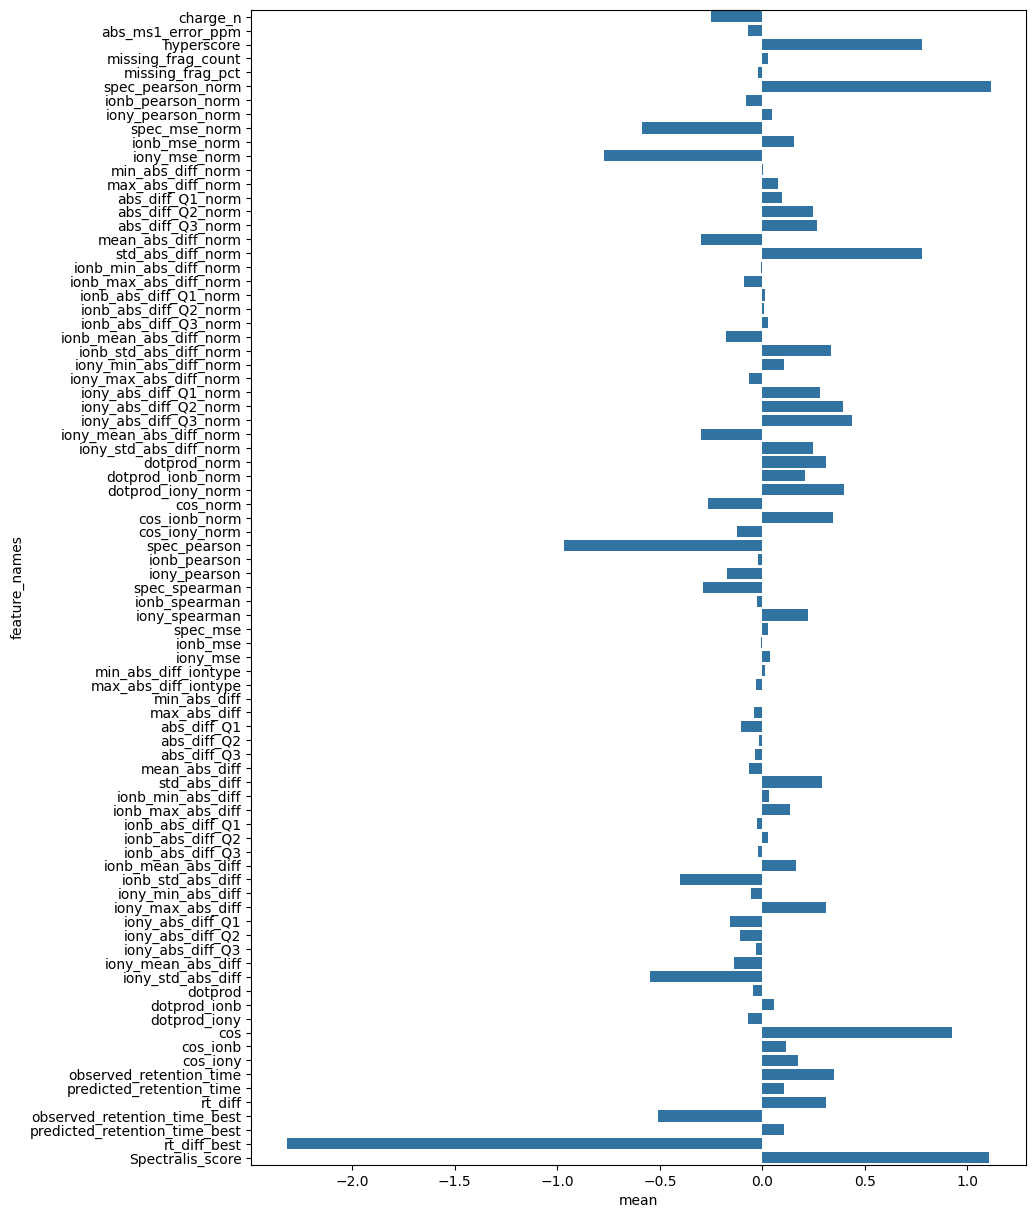

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,15))

sns.barplot(
    coefs_df,
    x='mean',
    y='feature_names'
)

---

# Check the sage score

In [195]:
test_psm = gt_psmlist[np.isin(
    gt_psmlist['spectrum_id'], np.array([
        'controllerType=0 controllerNumber=1 scan=51256',
        'controllerType=0 controllerNumber=1 scan=38491'
    ]))
]


In [212]:
from psm_utils import Peptidoform
test_psm[1].is_decoy = True
test_psm[0].peptidoform = Peptidoform('NSPNNLSGLSNPPGTPR/2')

In [191]:
load_pickle('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot/feature_names.pkl')

['feature:hyperscore',
 'feature:missing_frag_sites',
 'feature:missing_frag_pct',
 'feature:ppm_precursor',
 'feature:ppm_mean_y',
 'feature:ppm_mean_b',
 'feature:explained_y_pct',
 'feature:explained_b_pct',
 'feature:explained_all_pct',
 'feature:charge_n',
 'feature:spec_mse_norm',
 'feature:cos',
 'feature:observed_retention_time',
 'feature:rt_diff']

In [202]:
new_drs = DeNovoRescorer(config)
new_drs.load(
    calibration_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    mokapot_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot'
)

In [208]:
new_drs.rescore(
    psm_list=test_psm,
    denovo=True
)

In [213]:
test_psm['score']

array([4.48138272, 0.05357657])

In [215]:
test_pmlist_2 = casanovo_candidates_psmlist[
    casanovo_candidates_psmlist['spectrum_id']=='controllerType=0 controllerNumber=1 scan=51256'
]

In [ ]:
test_psms = test_psm + test_pmlist_2

In [218]:
new_drs.rescore(
    psm_list=test_psms,
    denovo=True
)

In [223]:
test_df = test_psms.to_dataframe()
test_df['score_new'] = test_df.apply(lambda x: x['provenance_data']['score_ms2rescore'], axis=1)
test_df['pep'] = test_df.apply(lambda x: x['metadata']['peptide_evidence'], axis=1)
test_df[['spectrum_id', 'score_new', 'rank', 'pep']]

,spectrum_id,score_new,rank,pep
0,controllerType=0 controllerNumber=1 scan=51256,4.4784115683515,1,NSPNNISGISNPPGTPR/2
1,controllerType=0 controllerNumber=1 scan=38491,1.5732388983220436,1,TAVC[UNIMOD:4]DIPPR/2
2,controllerType=0 controllerNumber=1 scan=51256,4.181022310643964,1,NSPNNLSGLSNPPGTPR/2
3,controllerType=0 controllerNumber=1 scan=51256,3.720152901999354,2,NSPNNLSGLSNPPG<PT>R/2
4,controllerType=0 controllerNumber=1 scan=51256,3.48173502536617,3,NSPNNLSGLSNPPP<AS>R/2
5,controllerType=0 controllerNumber=1 scan=51256,4.234132627622045,4,G<GS>PNNLSGLSNPPGTPR/2
6,controllerType=0 controllerNumber=1 scan=51256,4.098818191353888,5,NSP<GG>NLSGLSNPPGTPR/2
7,controllerType=0 controllerNumber=1 scan=51256,3.9800047529123326,6,SNPNNLSGLSNPPGTPR/2
8,controllerType=0 controllerNumber=1 scan=51256,4.106649808700925,7,ASPNNLSGLSNPPGTPR/2
9,controllerType=0 controllerNumber=1 scan=51256,3.6373124412337465,8,NSPNNLSGLSNPP<SA>PR/2


In [ ]:
specid = 'controllerType=0 controllerNumber=1 scan=51256'


,spectrum_id,rank,run,source,rescoring_features
8490,controllerType=0 controllerNumber=1 scan=51256,1,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.0004236798267811537, 'abs_di..."


- NSPNNISGISNPPGTPR: 4.4784
- NSPNNLSGLSNPPGTPR: 4.181

Only difference is I and L, check what features are different and generate again.

In [241]:
gt_f = pd.DataFrame(
    gt_features[gt_features['spectrum_id']==specid]['rescoring_features'].tolist()
).T
gt_f = gt_f.rename(columns={0: 'gt'})

cas_f = pd.DataFrame(casanovo_features[
    (casanovo_features['spectrum_id']==specid) &
    (casanovo_features['rank']==1)
]['rescoring_features'].tolist()).T
cas_f = cas_f.rename(columns={0: 'dn'})

fs = pd.concat([gt_f, cas_f], axis=1)

In [248]:
fs['diff'] = fs.apply(lambda x: np.round(float(x['gt']-x['dn']),3), axis=1)

In [252]:
fs[fs['diff']!=0].dropna()

,gt,dn,diff
predicted_retention_time,69.447217,71.112772,-1.666
predicted_retention_time_best,69.447217,71.112772,-1.666
rt_diff,1.960407,3.625963,-1.666
rt_diff_best,1.960407,3.625963,-1.666
search_engine_score,1.384035,0.979508,0.405


In [254]:
from denovo_utils.io.read import load_deeplc

dlc = load_deeplc(
    model_path_folder='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration',
    calibration_path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/calibration/deeplc_calibration.pkl'
)

In [260]:
my_psm = test_psms[0]

In [261]:
my_psm_I = my_psm.copy()
my_psm_L = my_psm.copy()

my_psm_I['rescoring_features'] = {}
my_psm_L['rescoring_features'] = {}

my_psm_I['peptidoform'] = Peptidoform('NSPNNISGISNPPGTPR/2')
my_psm_L['peptidoform'] = Peptidoform('NSPNNLSGLSNPPGTPR/2')

In [264]:
dlc_psmlist = PSMList(psm_list=[my_psm_I, my_psm_L])

In [265]:
dlc.add_features(
    dlc_psmlist
)

In [266]:
dlc_psmlist['rescoring_features']

array([{'observed_retention_time': 67.48680877685547, 'predicted_retention_time': 69.44720940950538, 'rt_diff': 1.9604006326499075, 'observed_retention_time_best': 67.48680877685547, 'predicted_retention_time_best': 69.44720940950538, 'rt_diff_best': 1.9604006326499075},
       {'observed_retention_time': 67.48680877685547, 'predicted_retention_time': 71.11277174060862, 'rt_diff': 3.625962963753153, 'observed_retention_time_best': 67.48680877685547, 'predicted_retention_time_best': 71.11277174060862, 'rt_diff_best': 3.625962963753153}],
      dtype=object)

---

Merge correct and false casanovo candidates

In [267]:
from denovo_utils.io.read import read_partitions_features, read_partitions_psmlist

In [ ]:
true_casanovo_psmlist = load_psmlist(
    psm_path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/psmlist/casanovo_true.parquet'
)
true_casanovo_features = pd.read_parquet(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/casanovo_true.parquet'
)

Loading results from casanovo_true.parquet: 100%|██████████| 352220/352220 [00:53<00:00, 6622.97it/s]


In [313]:
def read_partitions_psmlist(path, prefix_filename):
    psm_list_list = []
    for p in tqdm(glob(os.path.join(path, f'{prefix_filename}*'))):
        psm_list_list.append(load_psmlist(p))
    
    return PSMList(psm_list=list(chain(*[psmlist.psm_list for psmlist in psm_list_list])))

false_casanovo_psmlist = read_partitions_psmlist(
    path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/psmlist',
    prefix_filename='parquet'
)

100%|██████████| 26/26 [01:36<00:00,  3.72s/it]


In [ ]:
false_casanovo_features = read_partitions_features(
    path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features',
    prefix_filename='parquet'
)

100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


In [314]:
casanovo_psmlist_all = true_casanovo_psmlist + false_casanovo_psmlist

In [292]:
# Also add the Casanovo score and spectralis score to the false candidates

score_df_casanovo_candidates = pd.DataFrame({
    'Casanovo_score': false_casanovo_psmlist['score'], 
    'spectrum_id': false_casanovo_psmlist['spectrum_id'],
    'rank': false_casanovo_psmlist['rank']
})

spectralis_scores_candidates = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams_false/spectralis/casanovo',
    filename='LFQ_Orbitrap_DDA_QC_01'
)
spectralis_scores_candidates = spectralis_scores_candidates.rename(columns={'title': 'spectrum_id'})[['Spectralis_score', 'spectrum_id', 'rank']]

casanovo_merged = false_casanovo_features.merge(score_df_casanovo_candidates).merge(spectralis_scores_candidates)

# Add to the casanovo psmlist features
### Add Casanovo score
_ = casanovo_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Casanovo_score'],
        score_name='Casanovo_score'
    ),
    axis=1
)
### Add Spectralis score
_ = casanovo_merged.apply(
    lambda x: add_score_to_rescoring_features(
        rescoring_dict=x['rescoring_features'],
        score=x['Spectralis_score'],
        score_name='Spectralis_score'
    ),
    axis=1
)

Loading Spectralis results: 100%|██████████| 10/10 [00:01<00:00,  9.67it/s]


In [300]:
all_casanovo_features_concatted = pd.concat([casanovo_features, false_casanovo_features]).reset_index(drop=True)

In [301]:
all_casanovo_features_concatted.to_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/casanovo.parquet')

In [303]:
all_casanovo_features_concatted.spectrum_id.nunique()

60387

In [317]:
from denovo_utils.io.save import save_psmlist
save_psmlist(
    casanovo_psmlist_all,
    save_path='/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/psmlist/casanovo.parquet'
)